In [1]:
#importing modules
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath
import re
import unicodedata
from tqdm import tqdm
import gensim
import multiprocessing
import random
import pandas as pd
import numpy as np

In [2]:
#file I need
file = ('C:\\Users\\mjjyo\\OneDrive\\Desktop\\openavenuesmicrointernship\\open_ave_data.csv')
file = pd.read_csv(file)

In [3]:
#cleaning the file. 
#dropping unneeded column
file.drop('Unnamed: 0', axis=1)
#making all lowercase
file = file.apply(lambda x: x.astype(str).str.lower())
#getting rid of labels within data
file['findings'] = file['findings'].str.replace('findings', '')
file['clinicaldata'] = file['clinicaldata'].str.replace('clinical', '')
file['clinicaldata'] = file['clinicaldata'].str.replace('indication', '')
file['clinicaldata'] = file['clinicaldata'].str.replace('history', '')
file['clinicaldata'] = file['clinicaldata'].str.replace('data', '')
file['clinicaldata'] = file['clinicaldata'].str.replace('information', '')
file['ExamName'] = file['ExamName'].str.replace('exam', '')
file['impression'] = file['impression'].str.replace('impression', '')

In [4]:
file.dropna()

,Unnamed: 0,ReportText,findings,clinicaldata,ExamName,impression
0,0,exam: chest radiography exam date: 06/01/2019 ...,: lungs/pleura: no focal opacities evident. no...,: cough. \n\n,: chest radiography date: 06/01/2019 08:30 pm...,: normal 2-view chest radiography.
1,1,exam: chest radiography exam date: 05/23/2020 ...,: lungs/pleura: no focal opacities evident. no...,: chest pain. \n\n,: chest radiography date: 05/23/2020 12:03 pm...,: no acute cardiopulmonary abnormality.
2,2,exam: chest radiography exam date: 12/13/2019 ...,: lungs/pleura: no focal opacities evident. no...,: chest pain. \n\n,: chest radiography date: 12/13/2019 03:40 pm...,: no acute cardiopulmonary process.
3,3,exam: - chest-portable history: chest pain com...,: heart size appears normal. lungs clear. \n\n,: chest pain \n\n,: - chest-portable\n\ncomparison: none,: lungs clear
4,4,exam: chest radiography exam date: 06/17/2021 ...,: lungs/pleura: no focal opacities evident. no...,": chest pain, shortness of breath. \n\n",: chest radiography date: 06/17/2021 03:09 pm...,: normal single view chest.
...,...,...,...,...,...,...
949,982,chest radiograph: pa and lateral views history...,lungs: the lung fields demonstrate normal degr...,: r05 cough \n\n,chest radiograph: pa and lateral views\n\ncomp...,: no acute pulmonary disease.
950,983,exam description: x-ray single view chest. cli...,: the lungs are well expanded and are clear. t...,": 68 years male, sob \n\n",description: x-ray single view chest.\n\ntech...,: no evidence of acute intrathoracic disease. ...
951,984,exam: chest radiography exam date: 04/02/2018 ...,: lungs/pleura: no focal opacities evident. no...,: chest pain. \n\n,: chest radiography date: 04/02/2018 10:49 pm...,: normal single view chest.
952,985,exam: xr chest 1 vw history: chest pain techni...,: lines and tubes: none cardiomediastinal: the...,: chest pain \n\n,: xr chest 1 vw\n\ntechnique: chest ap view(s)...,: no acute cardiopulmonary process dictated by...


In [5]:
#files to do vector on
exam_names = file['ExamName'].dropna().tolist()

impressions= file['impression'].dropna().tolist()

findings = file['findings'].dropna().tolist()

clinical_data = file['clinicaldata'].dropna().tolist()


In [6]:
#making corpus
corpus = exam_names + impressions + findings + clinical_data


In [7]:
#function to clean data
def clean_data(w, stopwords):
    w = w.lower()
    w=re.sub(r'[^\w\s]','',w)
    w=re.sub(r"([0-9])", r" ",w)
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords) and len(word) > 2]
    return (clean_words)

In [49]:
#getting stopwords
stopwords_list=stopwords.words('english')
adjusted_corpus = []
#cleaning data and making it so the corpus is a list of lists of words
for i in corpus:
    cleaned = clean_data(i,stopwords_list)
    adjusted_corpus.append(cleaned)


In [9]:
#word2vec model
cores= multiprocessing.cpu_count()
model = Word2Vec(min_count=5,window=5,workers=cores-1,max_vocab_size=100000)

In [10]:
model.build_vocab(adjusted_corpus)

In [11]:
model.build_vocab(adjusted_corpus, update=True)

In [12]:
model.train(adjusted_corpus, total_examples=model.corpus_count,epochs=50)

(743015, 1566300)

In [13]:
path = r"C:\Users\mjjyo\OneDrive\Desktop\openavenuesmicrointernship\word2vecmodel"

In [14]:
model.save(path)


In [15]:
trained_model = gensim.models.Word2Vec.load(path)


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [17]:
def get_sentence_vectors(text):
    tokens = text.split()
    vectors = []
    for token in tokens:
        if token in trained_model.wv.index_to_key:
            vectors.append(trained_model.wv[token])
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros((trained_model.vector_size,))

In [35]:
X = np.array([get_sentence_vectors(text) for text in corpus])


In [36]:
height = 3816
y = pd.DataFrame(0, index=range(height), columns=range(1))

y.loc[0:953] = 'ExamName'
y.loc[954:1907] = 'impression'
y.loc[1908:2861] = 'findings'
y.loc[2862:3816] = 'clinicaldata'


In [38]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [40]:
lr_model = LogisticRegression(random_state=1234)
param_dict = {'C': [0.001, 0.01, 0.1, 1, 10],
             'solver': ['sag', 'lbfgs', 'saga']}

In [41]:
lr_model = LogisticRegression(random_state=1234)
lr_model.fit(x_train, y_train)
lr_preds = lr_model.predict(x_test)

C:\Users\mjjyo\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mjjyo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:

print(confusion_matrix(y_test, lr_preds))
print(classification_report(y_test, lr_preds))
print("Accuracy Score: %.3f" % accuracy_score(y_test, lr_preds))


[[309   6   0   0]
 [  0 315   5   1]
 [  0   0 325   6]
 [  0   4   8 281]]
              precision    recall  f1-score   support

    ExamName       1.00      0.98      0.99       315
clinicaldata       0.97      0.98      0.98       321
    findings       0.96      0.98      0.97       331
  impression       0.98      0.96      0.97       293

    accuracy                           0.98      1260
   macro avg       0.98      0.98      0.98      1260
weighted avg       0.98      0.98      0.98      1260

Accuracy Score: 0.976


In [55]:
def color_func(count):
    if 954 >= count > 0:
        return ('blue', 'Exam Name')
    elif 1908 >= count > 954:
        return ('red', 'Impression')
    elif 2862 >= count > 1908:
        return ('green', 'Findings')
    elif 3812 >= count > 2862:
        return ('yellow', 'Clinical Data')

In [51]:
X_embedded = TSNE(n_components = 2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)


TypeError: cannot unpack non-iterable NoneType object

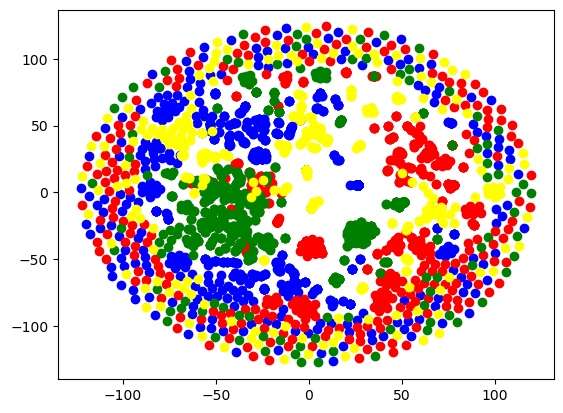

In [56]:
num = 1
for i in X_embedded:
    color, name = color_func(num)
    plt.scatter(i[0], i[1], c = color, label = name)
    num += 1
#Blue is Exam Name
#Red is Impression
#Green is findings
#Yellow is Clinical Data